# Final Report: OpenCV NLP Project

##### Dani Bojado and Matthew Mays

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import os
import requests
from requests import get
from os import path
from bs4 import BeautifulSoup

import json
import unicodedata

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from typing import Dict, List, Optional, Union, cast
from env import github_token, github_username
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import acquire as ac
import prepare

import warnings
warnings.filterwarnings("ignore")

## Acquire

- Scraped most starred OpenCV GitHub repositories 
- Wrote the python code necessary to extract the text of the README file for each page, and the primary language of the repository.
- Extracted a total of 150 repositories for our data set.

In [2]:
# Scrape data
url = 'https://github.com/search?o=desc&p={num}&q=OpenCV&s=stars&type=Repositories'
response = requests.get(url)

In [3]:
# Pull in repos using acquire function
urls = ac.get_all_urls() 
urls

['opencv/opencv_contrib',
 'openframeworks/openFrameworks',
 'PySimpleGUI/PySimpleGUI',
 'spmallick/learnopencv',
 'Hironsan/BossSensor',
 'opencv/opencv',
 'CMU-Perceptual-Computing-Lab/openpose',
 'Ewenwan/MVision',
 'oarriaga/face_classification',
 'vipstone/faceai',
 'bytedeco/javacv',
 'hybridgroup/gocv',
 'esimov/pigo',
 'jrosebr1/imutils',
 'peterbraden/node-opencv',
 'nuno-faria/tiler',
 'kelaberetiv/TagUI',
 'hamuchiwa/AutoRCCar',
 'justadudewhohacks/opencv4nodejs',
 'bijection/sistine',
 'shimat/opencvsharp',
 'Roujack/mathAI',
 'anandpawara/Real_Time_Image_Animation',
 'HuTianQi/SmartOpenCV',
 'amusi/AI-Job-Notes',
 'makelove/OpenCV-Python-Tutorial',
 'soruly/trace.moe',
 'CodecWang/OpenCV-Python-Tutorial',
 'mapillary/OpenSfM',
 'MasteringOpenCV/code',
 'kongqw/OpenCVForAndroid',
 'nagadomi/lbpcascade_animeface',
 'changwookjun/StudyBook',
 'opentrack/opentrack',
 'ivanseidel/Is-Now-Illegal',
 'oreillymedia/Learning-OpenCV-3_examples',
 'andrewssobral/bgslibrary',
 'tebelor

In [4]:
# Store repos into a json file
df = pd.read_json('data.json')

In [5]:
# 150 repos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             150 non-null    object
 1   language         144 non-null    object
 2   readme_contents  150 non-null    object
dtypes: object(3)
memory usage: 3.6+ KB


## Prepare

- Built a dataset
- Counted programming languages for each repo
- Prepared and cleaned data

In [6]:
# Built dataframe
df

,repo,language,readme_contents
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw...."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo..."
...,...,...,...
145,jerry1900/faceRecognition,Python,# faceRecognition\n利用OpenCV、CNN进行人脸识别\n万壑，4978...
146,lixiaoshaxing/MultiMediaLearn,C,# MultiMediaLearn\n多媒体学习：图片处理，音视频处理，相机使用，OpenG...
147,WL-Amigo/waifu2x-converter-cpp,C++,# waifu2x (converter only version)\n\nThis is ...
148,atulapra/Emotion-detection,Python,# Emotion detection using deep learning\n\n## ...


In [7]:
# Count programming languages in repos from dataframe
language_count = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
language_count.columns = ['n', 'percent']
language_count

,n,percent
Python,61,0.423611
C++,47,0.326389
Java,7,0.048611
JavaScript,6,0.041667
Jupyter Notebook,5,0.034722
Go,3,0.020833
C#,2,0.013889
Shell,2,0.013889
Objective-C,2,0.013889
Rust,1,0.006944


In [8]:
# Prepare data
df['text_cleaned'] = df.readme_contents.apply(prepare.basic_clean)
df['text_tokenized'] = df.text_cleaned.apply(prepare.tokenize)
df['text_lemmatized'] = df.text_tokenized.apply(prepare.lemmatize)
df['text_filtered'] = df.text_lemmatized.apply(prepare.remove_stopwords)
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...


In [9]:
# Create 'words' variable
words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]

# Add 'words' column to dataframe
# Column will contain lists of separated words in each repo
df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)

df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor..."
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...,"[p, aligncenter, img, srchttpsrawgithubusercon..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra..."
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...,"[div, aligncenter, img, srcgithublogomainblack..."


In [10]:
# There were null values in df.info() so we will be looking in to those to see which ones those were
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             150 non-null    object
 1   language         144 non-null    object
 2   readme_contents  150 non-null    object
 3   text_cleaned     150 non-null    object
 4   text_tokenized   150 non-null    object
 5   text_lemmatized  150 non-null    object
 6   text_filtered    150 non-null    object
 7   words            150 non-null    object
dtypes: object(8)
memory usage: 9.5+ KB


In [28]:
# We need to look at which repos have nulls for language
df[df.language.isnull()]

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words,bigrams,trigrams
24,amusi/AI-Job-Notes,None,# AI-Job-Notes\nAI算法岗求职攻略：涵盖校招时间表、准备攻略、刷题指南、内推...,aijobnotes\naiai\n\naislam\n\n issues\n\n \n...,aijobnotes\naiai\n\naislam\n\n issues\n\n \n\n...,aijobnotes aiai aislam issue markdowntoc depth...,aijobnotes aiai aislam issue markdowntoc depth...,"[aijobnotes, aiai, aislam, issue, markdowntoc,...","[(aijobnotes, aiai), (aiai, aislam), (aislam, ...","[(aijobnotes, aiai), (aiai, aislam), (aislam, ..."
32,changwookjun/StudyBook,None,# Study E-Book(ComputerVision DeepLearning Mac...,study ebookcomputervision deeplearning machin...,study ebookcomputervision deeplearning machine...,study ebookcomputervision deeplearning machine...,study ebookcomputervision deeplearning machine...,"[study, ebookcomputervision, deeplearning, mac...","[(study, ebookcomputervision), (ebookcomputerv...","[(study, ebookcomputervision), (ebookcomputerv..."
38,nagadomi/lbpcascade_animeface,None,# lbpcascade_animeface\n\nThe face detector fo...,lbpcascade_animeface\n\nthe face detector for...,lbpcascade_animeface\n\nthe face detector for ...,lbpcascade_animeface the face detector for ani...,lbpcascade_animeface face detector animemanga ...,"[lbpcascadeanimeface, face, detector, animeman...","[(lbpcascadeanimeface, face), (face, detector)...","[(lbpcascadeanimeface, face), (face, detector)..."
69,xiangjiana/Android-MS,None,[**版权声明**](#版权声明)\n\n# Android 高级面试\n\n### ![面...,\n\n android \n\n img2020androidpng\n \n andr...,android \n\n img2020androidpng\n \n androidhtt...,android img2020androidpng androidhttpswwwjians...,android img2020androidpng androidhttpswwwjians...,"[android, img2020androidpng, androidhttpswwwji...","[(android, img2020androidpng), (img2020android...","[(android, img2020androidpng), (img2020android..."
74,opencv/opencv_extra,None,### OpenCV: Open Source Computer Vision Librar...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library thi...,opencv open source computer vision library rep...,"[opencv, open, source, computer, vision, libra...","[(opencv, open), (open, source), (source, comp...","[(opencv, open), (open, source), (source, comp..."
144,huihut/OpenCV-MinGW-Build,None,# OpenCV-MinGW-Build\n\nMinGW 32bit and 64bit ...,opencvmingwbuild\n\nmingw 32bit and 64bit ver...,opencvmingwbuild\n\nmingw 32bit and 64bit vers...,opencvmingwbuild mingw 32bit and 64bit version...,opencvmingwbuild mingw 32bit 64bit version ope...,"[opencvmingwbuild, mingw, 32bit, 64bit, versio...","[(opencvmingwbuild, mingw), (mingw, 32bit), (3...","[(opencvmingwbuild, mingw), (mingw, 32bit), (3..."


In [29]:
# There are only 6 rows with two of them being in another language, these will simply be dropped
df = df[df.language.notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 149
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             144 non-null    object
 1   language         144 non-null    object
 2   readme_contents  144 non-null    object
 3   text_cleaned     144 non-null    object
 4   text_tokenized   144 non-null    object
 5   text_lemmatized  144 non-null    object
 6   text_filtered    144 non-null    object
 7   words            144 non-null    object
 8   bigrams          144 non-null    object
 9   trigrams         144 non-null    object
dtypes: object(10)
memory usage: 12.4+ KB


## Explore

### What are the most common words in READMEs?

### Most Common Single Words

In [30]:
# Create words variables for Python, C++, and All
python_words = ' '.join(df[df.language=='Python'].text_filtered)
c_plus_plus_words = ' '.join(df[df.language=='C++'].text_filtered)
all_words = ' '.join(df.text_filtered)

python_words = re.sub(r'\s.\s', '', python_words)
c_plus_plus_words = re.sub(r'\s.\s', '', c_plus_plus_words)
all_words = re.sub(r'\s.\s', '', all_words)

In [31]:
# Word Frequency 
python_freq = pd.Series(python_words.split()).value_counts()
c_plus_plus_freq = pd.Series(c_plus_plus_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

all_freq.head()

&#9;      925
image     884
opencv    714
using     440
build     388
dtype: int64

In [32]:
# Word Count for 'All', 'Python', and C++
word_counts = (pd.concat([all_freq, python_freq, c_plus_plus_freq], axis=1, sort=True)
               .set_axis(['All', 'Python', 'C++'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.sort_values(by='All', ascending=False).head(10)

,All,Python,C++
&#9;,925,105,534
image,884,600,153
opencv,714,156,244
using,440,156,138
build,388,25,222
tdtd,383,383,0
file,371,172,79
install,364,112,77
use,350,113,135
example,321,100,161


In [33]:
# Create variables for series
single_python_words = pd.Series(list(nltk.ngrams(python_words.split(), 1))).value_counts().head(20) 
single_c_plus_plus_words = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 1))).value_counts().head(20)
single_all_words = pd.Series(list(nltk.ngrams(all_words.split(), 1))).value_counts().head(20)

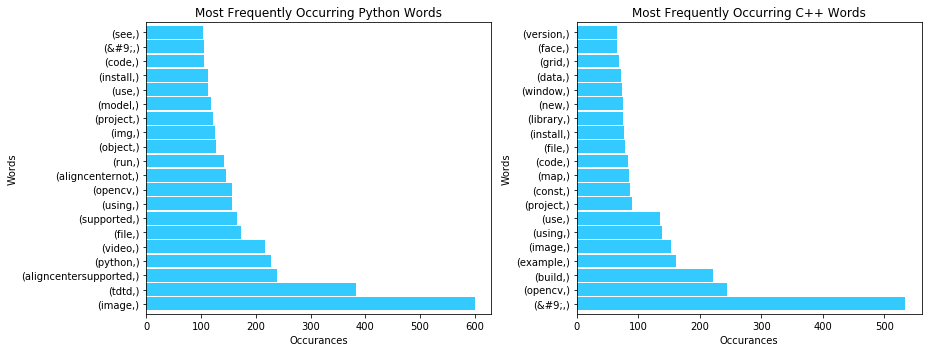

In [34]:
# Single Word Subplots (Python and C++) 
single_python_words.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
single_c_plus_plus_words.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))
single_all_words.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
single_python_words.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Words')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
single_c_plus_plus_words.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Words')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Occurances')

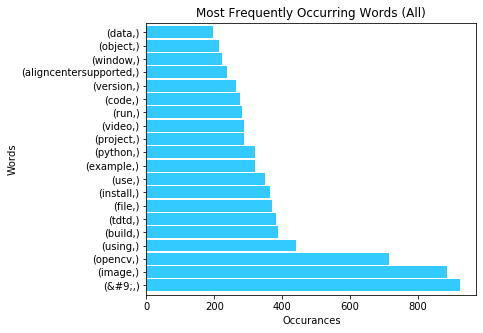

In [35]:
# Single Word Subplots (All) 
plt.subplot(121)
single_all_words.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Words (All)')
plt.ylabel('Words')
plt.xlabel('Occurances')

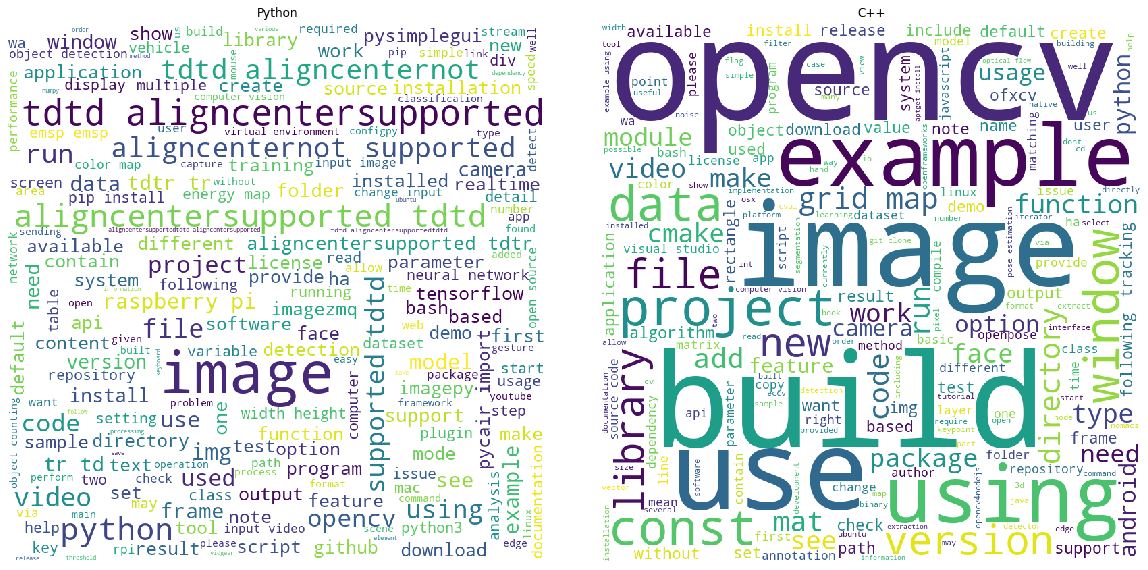

In [36]:
# Single Word, Word Clouds
python_cloud = WordCloud(background_color='white',
                      height=800, width=800).generate(python_words)

c_plus_plus_cloud = WordCloud(background_color='white', 
                      height=800, width=800).generate(c_plus_plus_words)

plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

# imshow => display data as an image
axs[0].imshow(python_cloud)
axs[1].imshow(c_plus_plus_cloud)

axs[0].set_title('Python')
axs[1].set_title('C++')

for ax in axs: ax.axis('off')

### Do different programming languages use a different number of unique words?

### Most Common Bigrams

In [37]:
# Added 'Bigram' column to dataframe
df['bigrams'] = [list(nltk.ngrams(wordlist, 2)) for wordlist in df.words]
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words,bigrams,trigrams
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz...","[(mvision, machine), (machine, vision), (visio...","[(mvision, machine), (machine, vision), (visio..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor...","[(repository, opencvs), (opencvs, extra), (ext...","[(repository, opencvs), (opencvs, extra), (ext..."
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...,"[p, aligncenter, img, srchttpsrawgithubusercon...","[(p, aligncenter), (aligncenter, img), (img, s...","[(p, aligncenter), (aligncenter, img), (img, s..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra...","[(opencv, open), (open, source), (source, comp...","[(opencv, open), (open, source), (source, comp..."
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...,"[div, aligncenter, img, srcgithublogomainblack...","[(div, aligncenter), (aligncenter, img), (img,...","[(div, aligncenter), (aligncenter, img), (img,..."


In [38]:
# Create variables for series
python_bigrams = pd.Series(list(nltk.ngrams(python_words.split(), 2))).value_counts().head(20) 
c_plus_plus_bigrams = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 2))).value_counts().head(20)

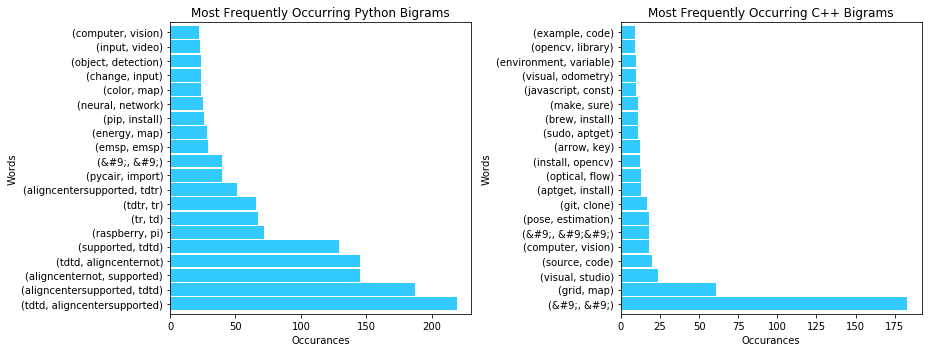

In [39]:
# Bigram Subplots 
python_bigrams.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
c_plus_plus_bigrams.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
python_bigrams.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Bigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
c_plus_plus_bigrams.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Bigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

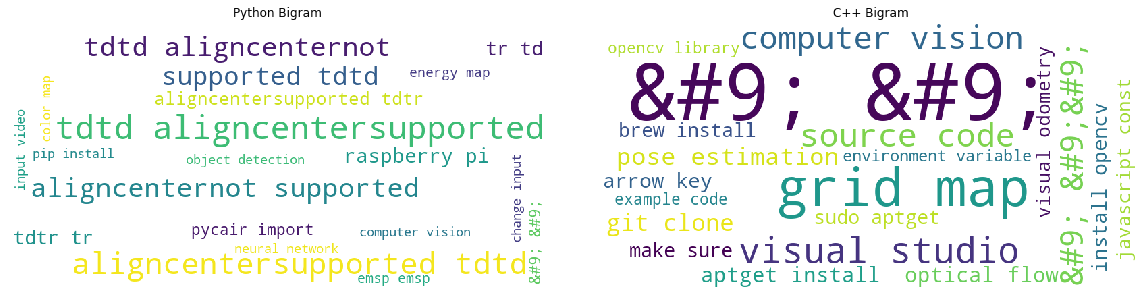

In [40]:
# Bigram Word Clouds
python_data = {k[0] + ' ' + k[1]: v for k, v in python_bigrams.to_dict().items()}
c_plus_plus_data = {k[0] + ' ' + k[1]: v for k, v in c_plus_plus_bigrams.to_dict().items()}

python_bigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(python_data)

c_plus_plus_bigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(c_plus_plus_data)


plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

axs[0].imshow(python_bigram_cloud)
axs[1].imshow(c_plus_plus_bigram_cloud)

axs[0].set_title('Python Bigram')
axs[1].set_title('C++ Bigram')

for ax in axs: ax.axis('off')

### Most Common Trigrams

In [41]:
# Added 'Trigram' column to dataframe
df['trigrams'] = [list(nltk.ngrams(wordlist, 2)) for wordlist in df.words]
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words,bigrams,trigrams
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz...","[(mvision, machine), (machine, vision), (visio...","[(mvision, machine), (machine, vision), (visio..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor...","[(repository, opencvs), (opencvs, extra), (ext...","[(repository, opencvs), (opencvs, extra), (ext..."
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...,"[p, aligncenter, img, srchttpsrawgithubusercon...","[(p, aligncenter), (aligncenter, img), (img, s...","[(p, aligncenter), (aligncenter, img), (img, s..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra...","[(opencv, open), (open, source), (source, comp...","[(opencv, open), (open, source), (source, comp..."
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...,"[div, aligncenter, img, srcgithublogomainblack...","[(div, aligncenter), (aligncenter, img), (img,...","[(div, aligncenter), (aligncenter, img), (img,..."


In [42]:
# Create variables for series
python_trigrams = pd.Series(list(nltk.ngrams(python_words.split(), 3))).value_counts().head(20)
c_plus_plus_trigrams = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 3))).value_counts().head(20)

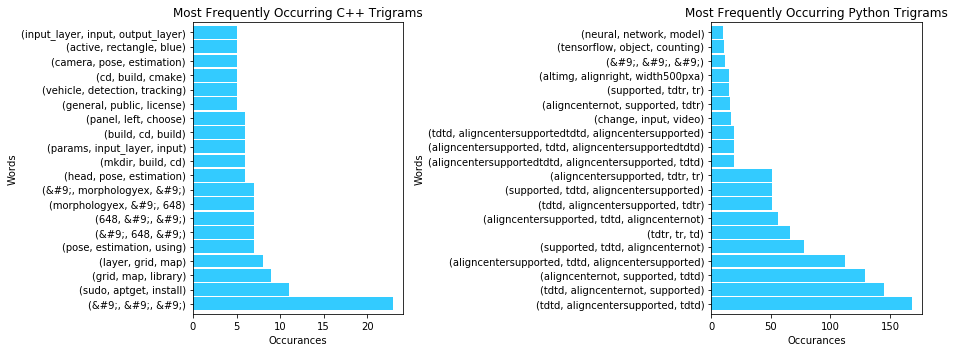

In [43]:
# Trigram Subplots 
# Switched Python and C++ graphs around to better align in this format
# Pay attention to the titles and labels
python_trigrams.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
c_plus_plus_trigrams.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
c_plus_plus_trigrams.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Trigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
python_trigrams.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Trigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

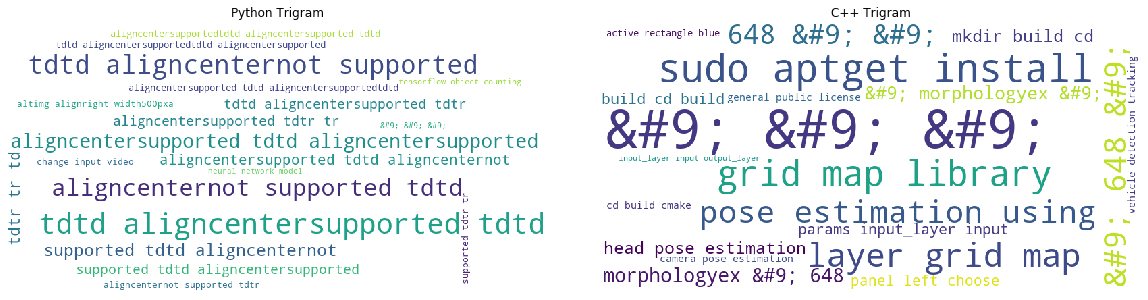

In [44]:
# Trigram Word Clouds
python_tridata = {k[0] + ' ' + k[1]+ ' ' + k[2]: v for k, v in python_trigrams.to_dict().items()}
c_plus_plus_tridata = {k[0] + ' ' + k[1]+ ' ' + k[2]: v for k, v in c_plus_plus_trigrams.to_dict().items()}

python_trigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(python_tridata)

c_plus_plus_trigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(c_plus_plus_tridata)


plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

axs[0].imshow(python_trigram_cloud)
axs[1].imshow(c_plus_plus_trigram_cloud)

axs[0].set_title('Python Trigram')
axs[1].set_title('C++ Trigram')

for ax in axs: ax.axis('off')

### What does the distribution of IDFs look like for the most common words?

### Does the length of the README vary by programming language?

## Model 

- Use the programming language of the repository as a predictive label.  


- Fit different models and using different representations of the text (e.g. simple bag of words, TF-IDF values).  


- Built a function that will take in the text of a README file and predict the programming language of repo.  

### Train, Validate, Test

In [26]:
# train_validate, test = train_test_split(df[['language', 'readme_contents']], 
                                        #stratify=df.language, 
                                        #test_size=.2)

# train, validate = train_test_split(train_validate, 
                                   #stratify=train_validate.language, 
                                   #test_size=.25)

### Bag of Words

### TF-IDF

### Function

## Conclusions/Takeaways

- Even though OpenCV is primarly written in C++, most words repos are written in Python  



- Repo Languages (out of 150 total most starred repos explored):  
    - Python 42.3% ; 61 repos  
    - C++ 32.6%, 47 repos  
    - Java 4.8%, 7 repos  
    
   
- We choose to only explore Python and C++ repos because there are the most significant   



- Combined total of 108 repos explored



- Most common words for Python and C++ combined are  &#9 ; , image, and opencv  



- Curious to know the meaning behind  &#9 ; ,could not find anything over it through Google search

## Future Investigations

- Are similar patterns seen across other computer vision software repos, such as (Matlab, TensorFlow, and SimpleCV)?